In this notebook, we show a simple walkthrough on how to use GMM-MI to calculate MI on your data. We also cover different scenarios and pitfalls that might arise, explaining how to deal with each different case.

# Walkthrough

### First, we import all needed packages, and create some mock data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.utils.analytic_MI import calculate_MI_D1_analytical

In [2]:
# create simple mock bivariate Gaussian data
N=int(1e4)
mean, cov = np.array([0, 0]), np.array([[1, 0.6], [0.6, 1]])
rng = np.random.default_rng(0)
X = rng.multivariate_normal(mean, cov, N) # has shape (N, 2)
# recall that we an analytic expression for MI in this simple case
analytic_MI = calculate_MI_D1_analytical(cov)
print(f'Analytic MI value is: {analytic_MI:.3f} nats')

Analytic MI value is: 0.223 nats


### At this point, we need to setup GMM-MI with its hyperparameters.
There are three main classes to set the hyperparameters.

`GMMFitParamHolder` allows to select the initialization type (default: `init_type=random_sklearn`, with more info [here](https://github.com/dpiras/MI_estimation/blob/main/gmm_mi/initializations.py#L162)), the log-likelihood threshold (default: `threshold_fit=1e-5`), the covariance regularization (default: `reg_covar=1e-15`) and the maximum number of log-likelihood updates (default: `max_iter=10000`) on each individual GMM fit. These parameters are set for all GMM fits that are run within GMM-MI, i.e. for the cross-validation fits and the bootstrap fits.

`SelectComponentsParamHolder` allows to specify the hyperparameters pertaining to cross-validation and selecting the number of GMM components. These are the number of different initializations (default: `n_inits=3`), the number of different folds (default: `n_folds=2`), the metric to track to choose the number of components (either the validation log-likelihood, the AIC or the BIC, default: `metric_method='valid'`), the threshold on the metric value to stop adding components (default: `threshold_components=1e-5`), how many more components to wait before stopping adding components (default: `patience=1`), the maximum number of GMM components to fit (default: `max_components=50`). If you prefer to fix the number of GMM components, you can specify `fixed_components_number` (default: `fixed_components_number=0`, which means that the number of components will be chosen based on the metric specified though `metric_method`.

`MIDistParamHolder` controls the parameters for calculating the MI distribution; more specifically, it controls the integral approximation and the bootstrap details. These are the number of bootstrap realizations (default: `n_bootstrap=50`), the method to approximate the integral (either MonteCarlo or quadrature, default: `MI_method='MC'`), the number of MonteCarlo samples in case MonteCarlo integration is being used (default: `MC_samples=1e5`). 

All parameters that are not indicated are set to their default values. We can also use `verbose=True` to print out useful statements when fitting.

Confused? Just follow the next two cells!

In [3]:
# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(init_type="random_sklearn",
                                   threshold_fit=1e-5,
                                   reg_covar=1e-15,
                                   max_iter=10000)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=3,
                                                       n_folds=2,
                                                       metric_method='valid',
                                                       threshold_components=1e-5,
                                                       patience=1,
                                                       max_components=50,
                                                       fixed_components_number=0)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=50,
                                   MI_method='MC',
                                   MC_samples=1e5)

Now, we only need to create an estimator with these hyperparameters, and fit the given data.

In [4]:
mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
# calculate MI
# X is your data, which should have shape of (n_samples, 2)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.3f} \pm {MI_std:.3f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -2.608. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 1 GMM components.
Starting MI integral estimation...


100%|██████████| 50/50 [00:01<00:00, 36.72it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.220 \pm 0.007 nats


The results are well in agreement with the ground truth - hooray! But what if something goes wrong?

# Common scenarios

For example, consider the following scenario. Let's consider a much more complicated dataset: a Gaussian mixture model made of 5 components - in the paper, we called this D5p. Let's first show how GMM-MI can successfully work on this dataset as well.

In [5]:
from gmm_mi.data.synthetic_data import D5p as dataset
from gmm_mi.gmm import GMMWithMI as GMM

random_state = 13
N = 1e4
label = 'D5p'
analytic = np.load(f'./synthetic_GMMs/MI_synthetic_datasets/MI_{label}.npy')
print(f'True MI: {analytic:.3f} nats')

# true GMM parameters
n_components = dataset.n_components 
true_weights = dataset.weights_
true_means = dataset.means_
true_covariances = dataset.covariances_

X = GMM(n_components=n_components, weights_init=true_weights, 
        means_init=true_means, covariances_init=true_covariances, 
        random_state=random_state).sample(N)[0]  

True MI: 0.180 nats


In [6]:
# let's keep the same hyperparameters
mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.3f} \pm {MI_std:.3f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -3.159. Adding one component...
Current number of GMM components: 2. Current metric: -2.996. Adding one component...
Current number of GMM components: 3. Current metric: -2.852. Adding one component...
Current number of GMM components: 4. Current metric: -2.802. Adding one component...
Current number of GMM components: 5. Current metric: -2.772. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 5 GMM components.
Starting MI integral estimation...


100%|██████████| 50/50 [00:07<00:00,  7.08it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.185 \pm 0.005 nats


Again, all good: GMM-MI returns a value of MI which is within 1 standard deviation of the ground truth. 

## The fit does not seem to capture the data distribution

However, you might need a faster answer, so you decide you want to be less conservative in the choice of some hyperparameters. For example, you relax the `threshold_fit` from 1e-5 to 1e-3 (leaving everything else unchanged).

In [7]:
# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-3)

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.3f} \pm {MI_std:.3f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -3.159. Adding one component...
Current number of GMM components: 2. Current metric: -3.158. Adding one component...
Current number of GMM components: 3. Current metric: -3.157. Adding one component...


/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/gmm_mi/mi.py:360: ConvergenceWarning: All CV GMM fits converged only after their second iteration for all components; this is usually suspicious, and might be a symptom of a bad fit. Plot the loss curves as described in the walkthrough, and try reducing threshold_fit, or with a different init_type.
  warnings.warn(


Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 3 GMM components.
Starting MI integral estimation...


100%|██████████| 50/50 [00:09<00:00,  5.45it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.105 \pm 0.004 nats


As you can see, the fitter in this case stops at 3 GMM components, and returns a heavily biased estimate of MI. This is also flagged by GMM-MI, which raises a warning. In any case, you can check how the best fitted model looks on top of your data:

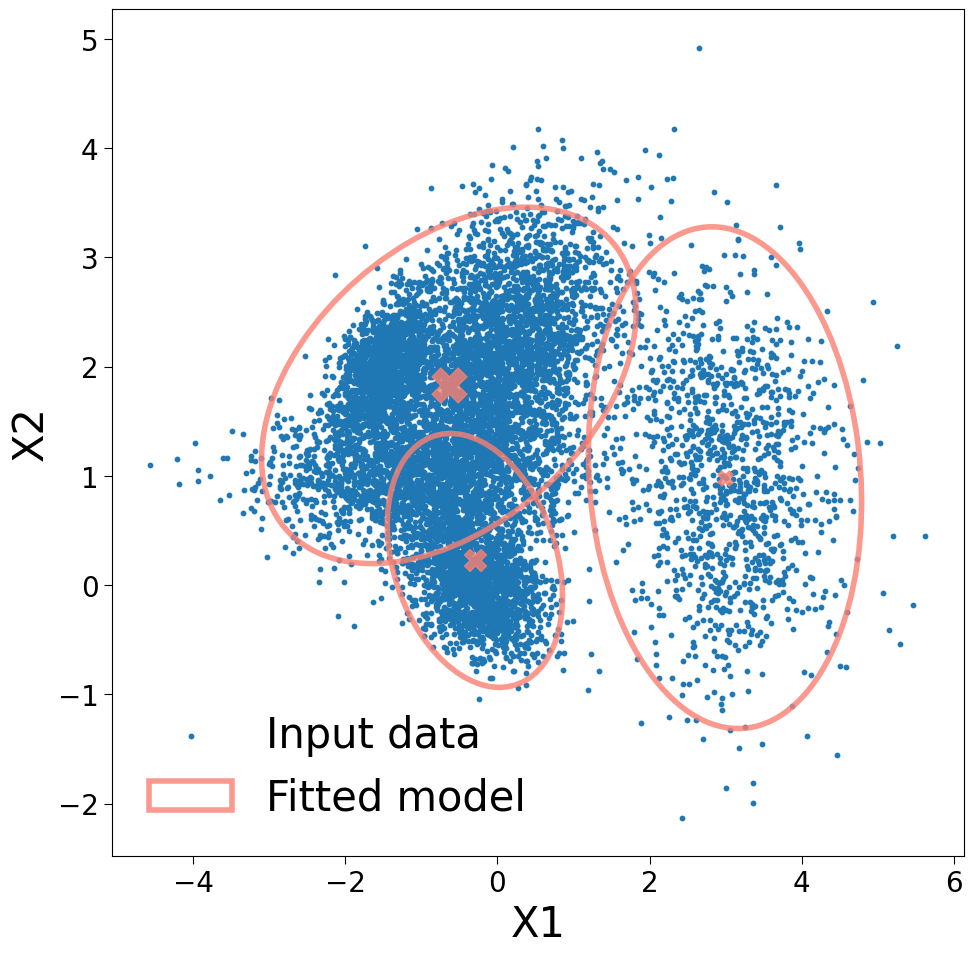

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

The fit is not terrible, but it leaves out some important features, especially on the left-hand side of the point cloud. We recommend always looking at the fitted model on top of your data in order not to bias your MI estimates, and lower `threshold_fit` if it does not look right. Another possibility is that your fit is stuck in a local optimum: in that case, make sure that you have set enough `n_inits`. 

Alternatively, you can try and see if with a different initialization type the fitter is able to capture your data distribution. In this case, we try with the K-means implementation provided by `sklearn`, still keeping the threshold to 1e-3. You can read [here](https://github.com/dpiras/MI_estimation/blob/main/gmm_mi/initializations.py#L162) about all initialization types currently available.

In [9]:
# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-3, init_type='kmeans_sklearn')

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.3f} \pm {MI_std:.3f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -3.159. Adding one component...
Current number of GMM components: 2. Current metric: -2.994. Adding one component...
Current number of GMM components: 3. Current metric: -2.857. Adding one component...
Current number of GMM components: 4. Current metric: -2.826. Adding one component...
Current number of GMM components: 5. Current metric: -2.775. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 5 GMM components.
Starting MI integral estimation...


100%|██████████| 50/50 [00:05<00:00,  9.41it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.180 \pm 0.005 nats


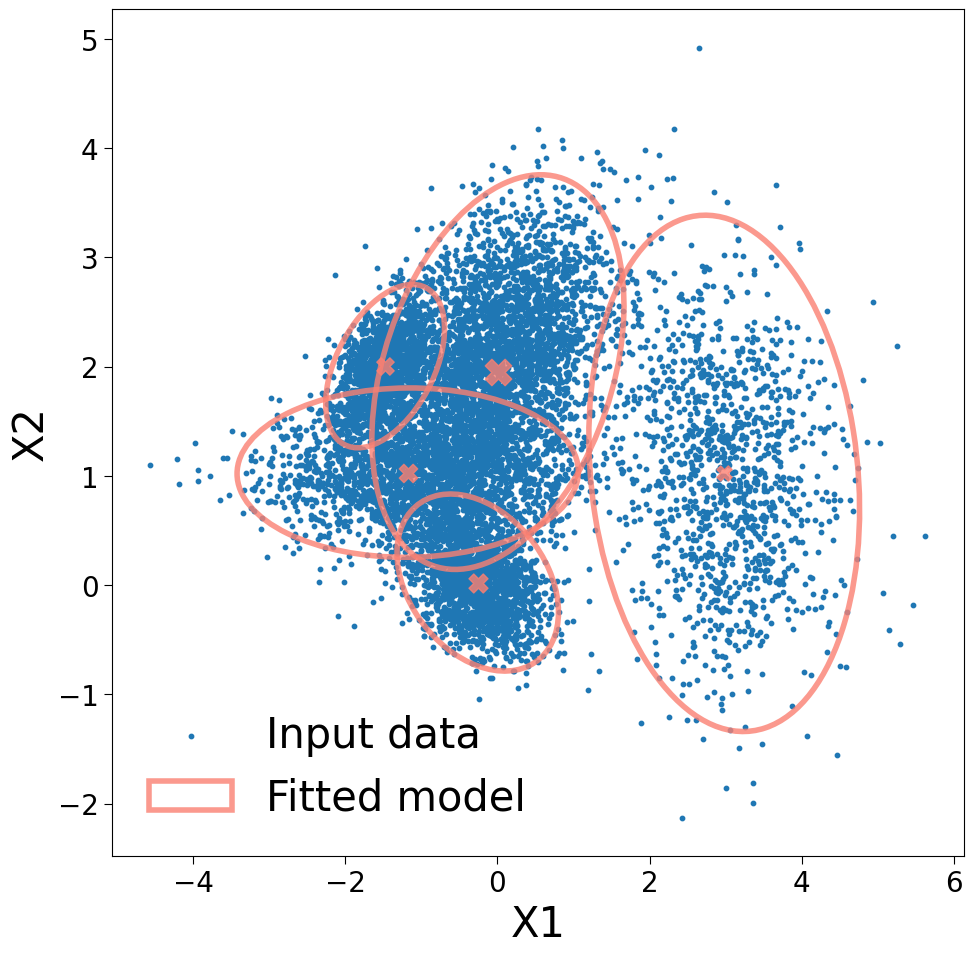

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

With a different initialization, the fitter was able to find the correct number of GMM components, and returned a consistent value of MI. However, there is no guarantee that the K-means initialization is better than the others, so always check the fitted model contours on top of your data.

A similar result can be obtained with the random initialization, but by changing the metric that is tracked to select the number of components. For instance, we can use the Akaike information criterion [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion); we also set the `threshold_component` to 0, so that the fitter will stop only if AIC becomes worse.

In [11]:
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-3, init_type='random_sklearn')
select_components_params = SelectComponentsParamHolder(metric_method='aic')

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.3f} \pm {MI_std:.3f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -63173.465. Adding one component...
Current number of GMM components: 2. Current metric: -63136.440. Adding one component...
Current number of GMM components: 3. Current metric: -57070.085. Adding one component...
Current number of GMM components: 4. Current metric: -56762.566. Adding one component...
Current number of GMM components: 5. Current metric: -56216.931. Adding one component...
Current number of GMM components: 6. Current metric: -55436.261. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 6 GMM components.
Starting MI integral estimation...


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.168 \pm 0.024 nats


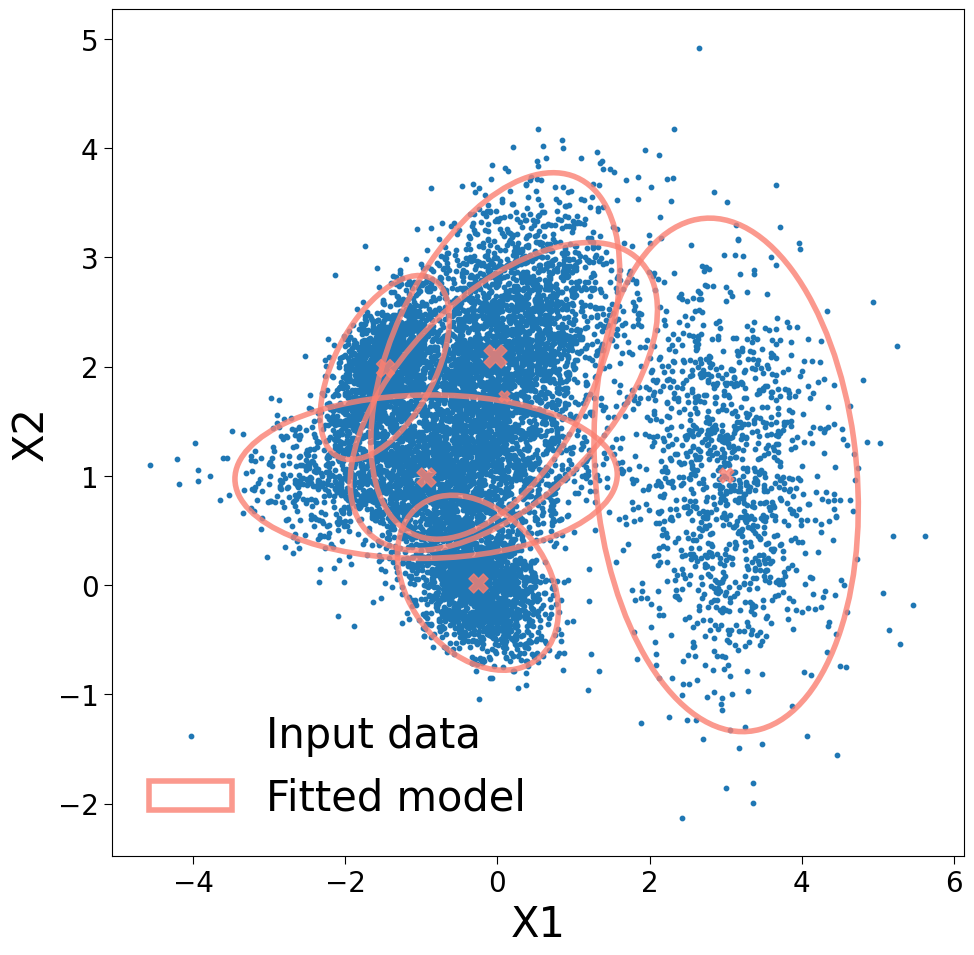

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

In this case, the fitter found one extra component, but the final estimate of MI is still consistent with the ground truth, and the fit looks good. There is no "best" way to select the number of GMM components, so you should always ensure you look at the fitted density estimator and decide it is good enough! 

As a final example, consider also this particularly weird distribution, where each marginal is uniformly distributed in some range.

## The fit returns overlapping components, with MI very close to 0 nats

When you have a larger number of data points and your threshold is not small enough, you might observe the following: the fitter finds one or more components, but they are all overlapping and do not really describe the data well. This is a combination of two effects: the random initialization gets stuck in a local optimum, and the threshold on each fit is not small enough. This is a [known limitation of GMMs](https://github.com/pmelchior/pygmmis/issues/18), which can be easily fixed with GMM-MI. In the following example, we increase the number of points and keep the fit threshold to 1e-3. We also return the loss curves of cross-validation by specifying `return_lcurves=True`.

In [14]:
N = 1e5

X = GMM(n_components=n_components, weights_init=true_weights, 
        means_init=true_means, covariances_init=true_covariances, 
        random_state=random_state).sample(N)[0]  

gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-3)
select_components_params = SelectComponentsParamHolder()

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std, lcurves = mi_estimator.fit(X, verbose=True, return_lcurves=True)
print(f'Estimated MI: {MI_mean:.4f} \pm {MI_std:.4f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -3.162. Adding one component...
Current number of GMM components: 2. Current metric: -3.162. Adding one component...
Current number of GMM components: 3. Current metric: -3.162. Adding one component...
Current number of GMM components: 4. Current metric: -3.162. Adding one component...


/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/gmm_mi/mi.py:360: ConvergenceWarning: All CV GMM fits converged only after their second iteration for all components; this is usually suspicious, and might be a symptom of a bad fit. Plot the loss curves as described in the walkthrough, and try reducing threshold_fit, or with a different init_type.
  warnings.warn(


Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 4 GMM components.
Starting MI integral estimation...


100%|██████████| 50/50 [00:08<00:00,  5.97it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.0020 \pm 0.0001 nats


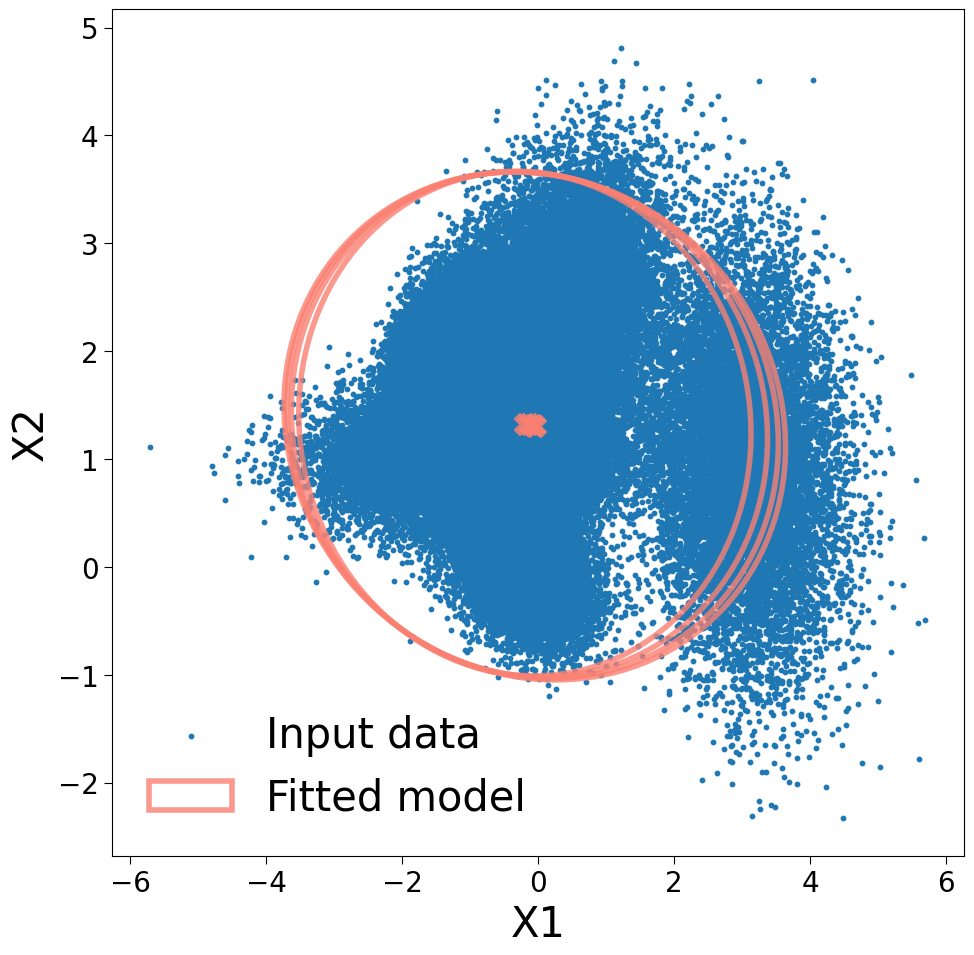

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

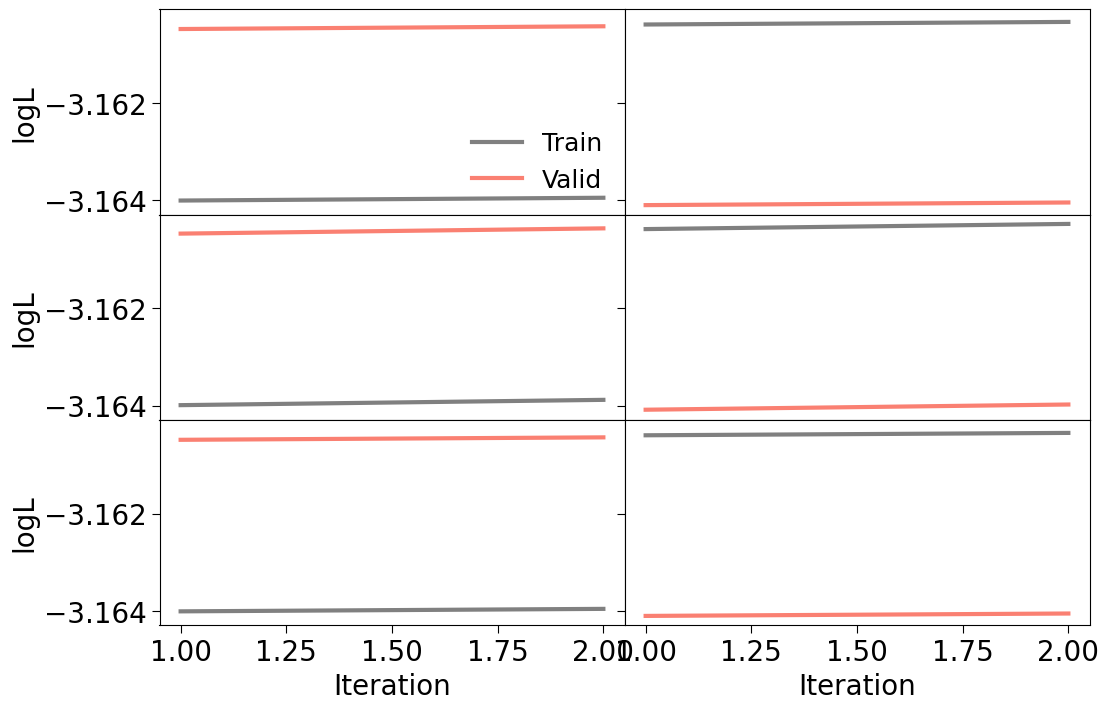

In [16]:
from gmm_mi.utils.plotting import plot_loss_curves
# with this, we also need to specify the number of folds and inits, which were the default ones
plot_loss_curves(lcurves, n_inits=3, n_folds=2, figsize=(12, 8))

The fitter got clearly stuck, and the results do not really make sense - each fit with 4 components only lasted 1 iteration. In this case, the fix can be usually obtained by changing the initialization type (again, e.g. to `random_sklearn`) or by lowering the threshold (or both). 

In [17]:
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5)
select_components_params = SelectComponentsParamHolder()

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std, lcurves = mi_estimator.fit(X, verbose=True, return_lcurves=True)
print(f'Estimated MI: {MI_mean:.4f} \pm {MI_std:.4f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -3.162. Adding one component...
Current number of GMM components: 2. Current metric: -2.998. Adding one component...
Current number of GMM components: 3. Current metric: -2.862. Adding one component...
Current number of GMM components: 4. Current metric: -2.828. Adding one component...
Current number of GMM components: 5. Current metric: -2.780. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 5 GMM components.
Starting MI integral estimation...


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.1801 \pm 0.0014 nats


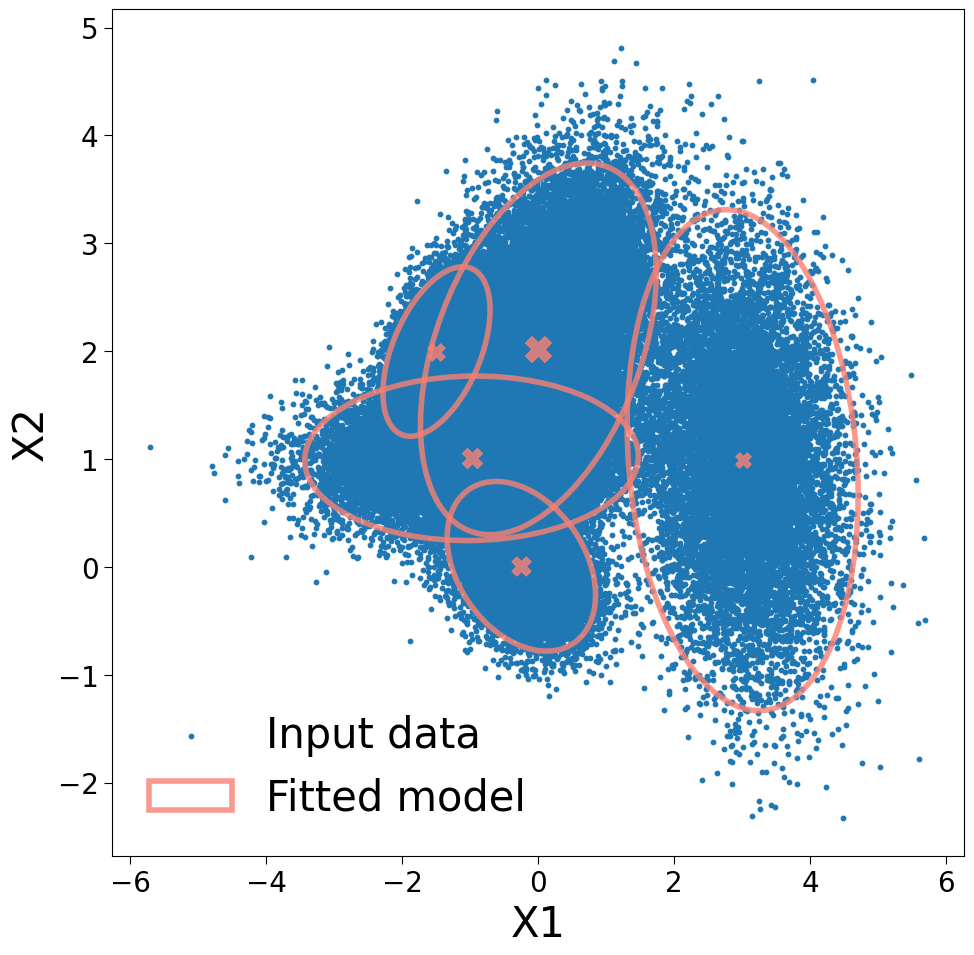

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

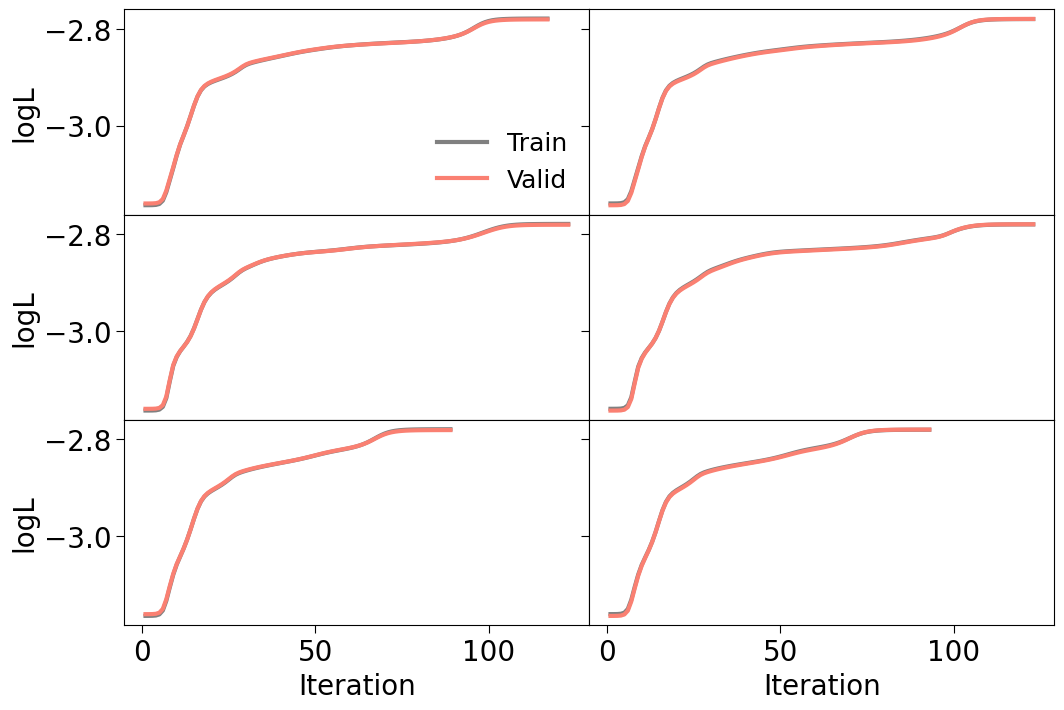

In [19]:
plot_loss_curves(lcurves, n_inits=3, n_folds=2, figsize=(12, 8))

With the right initialization and a low-enough threshold, you should be able to fit your data, and check the actual convergence with the contour plot and the loss curves.

# My fit does not seem to converge and keeps on adding components

In general, make sure you specified `verbose=True` at least when debugging, so that you know how many components are being fitted at every time. Consider the following case, where we fit a particularly weird distribution, i.e. a square point cloud (each marginal is uniform). Let's also recall that we are saying we will stop adding components when the change in the validation log-likelihood is less than 1e-5.

In [20]:
N = 5000
X1 = rng.uniform(0, 1, N).reshape(-1, 1)
X2 = rng.uniform(-1, 0, N).reshape(-1, 1)+1
X = np.concatenate((X1, X2), axis=1)

In [21]:
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5)
select_components_params = SelectComponentsParamHolder(threshold_components=1e-5)
mi_dist_params = MIDistParamHolder()

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.4f} \pm {MI_std:.4f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -0.350. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 1 GMM components.
Starting MI integral estimation...


100%|██████████| 50/50 [00:00<00:00, 51.11it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.0001 \pm 0.0002 nats


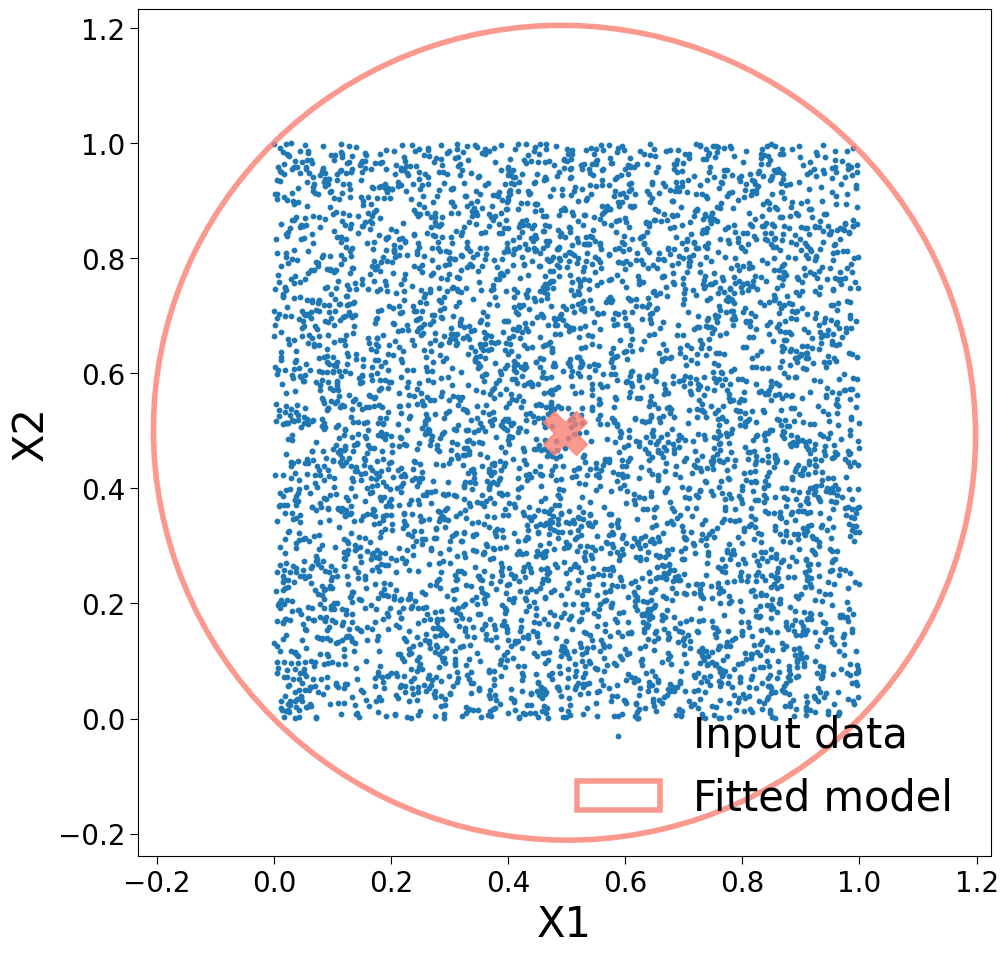

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

Even with `threshold_fit=1e-5`, GMM-MI only finds one component, which, even if beautifully symmetric, does not represent not a good density estimation of the data. So we go crazy and lower the threshold to 1e-8: what happens? (spoiler: it will take much longer!)

In [30]:
# careful: this will take up to 1h!
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-8)
select_components_params = SelectComponentsParamHolder(threshold_components=1e-5)
mi_dist_params = MIDistParamHolder()

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.3f} \pm {MI_std:.3f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -0.346. Adding one component...
Current number of GMM components: 2. Current metric: -0.302. Adding one component...
Current number of GMM components: 3. Current metric: -0.253. Adding one component...



KeyboardInterrupt



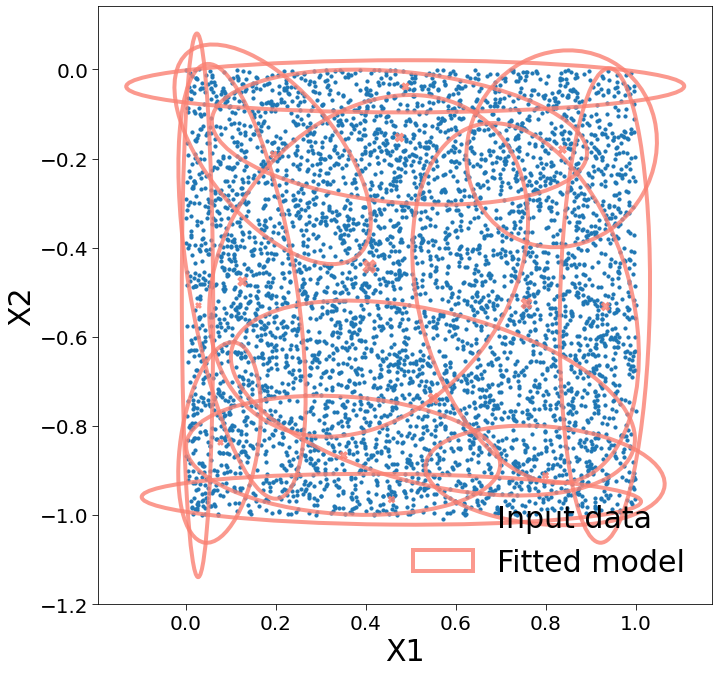

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

With 16 components, GMM-MI has finally captured the data better; however, with so many components, we clearly start overfitting the data, and the computational time becomes prohibitive. In this case, the solution is to find a good balance between the threshold on each fit, and the threshold to select the number of GMM components. We can notice that the change in the validation log-likelihood is of order 1e-2&ndash;1e-3 after 5 components, so we just increase the `threshold_components`.

In [40]:
# careful: this will take up a few mins!
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-8)
select_components_params = SelectComponentsParamHolder(threshold_components=1e-2)
mi_dist_params = MIDistParamHolder()

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.3f} \pm {MI_std:.3f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -0.357. Adding one component...
Current number of GMM components: 2. Current metric: -0.316. Adding one component...
Current number of GMM components: 3. Current metric: -0.244. Adding one component...
Current number of GMM components: 4. Current metric: -0.203. Adding one component...
Current number of GMM components: 5. Current metric: -0.186. Adding one component...
Current number of GMM components: 6. Current metric: -0.139. Adding one component...
Current number of GMM components: 7. Current metric: -0.120. Adding one component...
Current number of GMM components: 8. Current metric: -0.109. Adding one component...
Current number of GMM components: 9. Current metric: -0.097. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 9 GMM compone

100%|██████████| 50/50 [02:17<00:00,  2.75s/it]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.026 \pm 0.002 nats


In [ ]:
Estimated MI: 0.019 \pm 0.001 nats

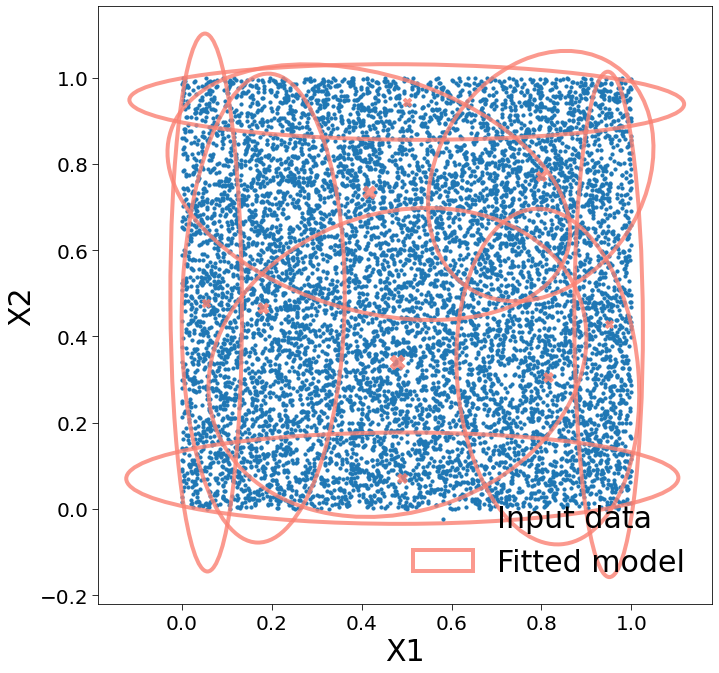

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

Arguably, a more sensible fit!

In [64]:
X[:, 0] = np.log(X[:, 0] / (1-X[:, 0]))
X[:, 1] = np.log(X[:, 1] / (1-X[:, 1]))

In [68]:
# careful: this will take up a few mins!
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-6, init_type='random')
select_components_params = SelectComponentsParamHolder(threshold_components=1e-2)
mi_dist_params = MIDistParamHolder(n_bootstrap=500)

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X, verbose=True)
print(f'Estimated MI: {MI_mean:.3f} \pm {MI_std:.3f} nats')

Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -4.024. Adding one component...
Current number of GMM components: 2. Current metric: -3.998. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 2 GMM components.
Starting MI integral estimation...


100%|██████████| 500/500 [00:53<00:00,  9.27it/s]

MI estimation completed, returning mean and standard deviation.
Estimated MI: 0.006 \pm 0.001 nats


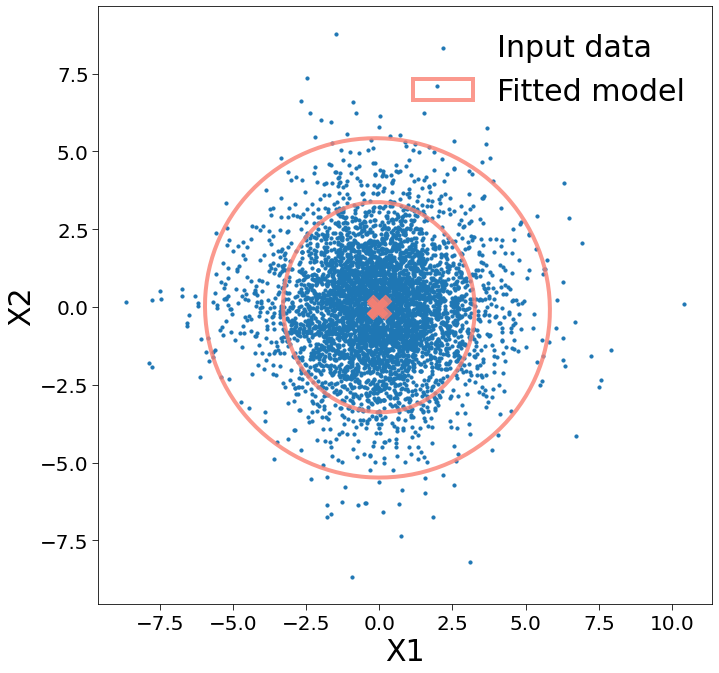

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
# X is the array with the input data
ax.scatter(X[:, 0], X[:, 1], label='Input data', s=10)
fig, ax = mi_estimator.plot_fitted_model(ax=ax)

## Any other problems which are not covered here?
Help us make GMM-MI better! If you have trouble fitting GMM-MI on your data, please [raise an issue](https://github.com/dpiras/MI_estimation/issues) on the repository, or contact [Davide Piras](mailto:dr.davide.piras@gmail.com). We will update this notebook based on your suggestions, so keep an eye out here as well!